# **Assignment 5 - CNN on Fashion MNIST**



---

This notebook is laid out as follows:



1.   **Part 1:** Input Pipeline
2.   **Part 2:** Define and Train a Model (no BatchNorm or Dropout)
3.  **Part 3:** Improve Model with BatchNorm and Dropout
4.   **Conclusions**



## **Part 1: Input Pipline**


Building a pipeline will first require us to obtain the dataset. Following which, we can add transformations to the data. 

---



*   To transform the dataset, **`tensorflow.keras.ImageDataGenerator`** is used. 

*   This has the advantage of **transforming images on the fly (in memory) and feeding it to the model.** 

*   It gives a **clean and optimized pipeline** without having to save transformed images to disk. 

*   It also makes sure that the model gets a **different set of transformed images per epoch.** 


---








### **Dependencies and Imports**

In [ ]:
!pip install -q idx2numpy

In [ ]:
import os
import idx2numpy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization, PReLU, Concatenate, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import Image

### **Load Dataset**

In [ ]:
# Download the dataset from source
!wget https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-images-idx3-ubyte.gz?raw=true -P /content/data/
!wget https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-labels-idx1-ubyte.gz?raw=true -P /content/data/
!wget https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-images-idx3-ubyte.gz?raw=true -P /content/data/
!wget https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/train-labels-idx1-ubyte.gz?raw=true -P /content/data/

# Rename files for !gunzip
for file in os.listdir('/content/data'):
  os.rename(os.path.join('/content/data', file), os.path.join('/content/data', file.replace('?raw=true', '')))

# Decompress the files using !gunzip
!gunzip '/content/data/t10k-images-idx3-ubyte.gz'  '/content/data/t10k-labels-idx1-ubyte.gz'  '/content/data/train-images-idx3-ubyte.gz'  '/content/data/train-labels-idx1-ubyte.gz'

# Convert from IDX to NumPy
array_list = list()
for file in sorted(os.listdir('/content/data')):
  imagefile = os.path.join('/content/data', file)
  imagearray = idx2numpy.convert_from_file(imagefile)
  array_list.append(imagearray)

# Load the data into x_train and y_train
x_test = array_list[0]
y_test = array_list[1]
x_train = array_list[2]
y_train = array_list[3]

# One hot encode the labels (classification task)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape x_train and x_test
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

# Verify the shapes
print('-' * 50)
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_test is {}'.format(y_test.shape))
print('-' * 50)

--2020-08-02 19:38:11--  https://github.com/zalandoresearch/fashion-mnist/blob/master/data/fashion/t10k-images-idx3-ubyte.gz?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2020-08-02 19:38:11--  https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz [following]
--2020-08-02 19:38:12--  https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/data/fashion/t10k-images-idx3-ubyte.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.1

### **Building the Pipeline**






In [ ]:
# Configure the transformations to be performed on the input
datagen = ImageDataGenerator(
        rescale= 1/255.0,
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,    
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split = 0.05
        )

## **Part 2: Define and Train a Model (no BatchNorm or Dropout)**

In this part we train a model from scratch (without BatchNorm and Dropout).

We have used **`tensorflow.keras`** and its **Functional API** to build our model. 

---

The key points of the architecture are as follows:

1. **Modular:** The architecture is broken down into repetetive 'blocks' as has become customary since models like Inception, ResNet, DenseNet etc.

2. **Light:** The focus is to build a model with ~0.1M or ~100K parameters and still have test accuracy that can rival official benchmarks. 

3. **Dimensionality Reduction and GlobalAveragePooling**: We opt for using a 1x1 Convolution (for reducing dimensionality) followed by GlobalAveragePooling as a collapsing layer rather than a Dense (fully connected) layer to drastically reduce the number of parameters required. 

4. **Feature Map Concatenation**: The model shares feature maps across layers in a 'block' via concatenation to enable sharing of features and improve gradient flow. 

5. **Swish Activation:** The model uses Swish activation function instead of the more customary ReLU and its variants since Swish offers slight improvement. 



---







### **Define Model**




In [ ]:
input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

# Block 1
x1_1 = Conv2D(16, (3, 3), padding='same')(input)
x1_1 = swish(x1_1)
x1_2 = Conv2D(16, (3, 3), padding='same')(x1_1)
x1_2 = swish(x1_2)
x = Concatenate(axis=-1)([x1_1, x1_2])
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x2_1 = Conv2D(32, (3, 3), padding='same')(x)
x2_1 = swish(x2_1)
x2_2 = Conv2D(32, (3, 3), padding='same')(x2_1)
x2_2 = swish(x2_2)
x = Concatenate(axis=-1)([x2_1, x2_2])
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 3
x3_1 = Conv2D(64, (3, 3), padding='same')(x)
x3_1 = swish(x3_1)
x3_2 = Conv2D(64, (3, 3), padding='same')(x3_1)
x3_2 = swish(x3_2)
x = Concatenate(axis=-1)([x3_1, x3_2])
x = MaxPooling2D(pool_size=(2, 2))(x)


# Reduce dimensionality and Global Average Pooling
reduce_dim = Conv2D(64, (1, 1), padding='same')(x)
reduce_dim = swish(reduce_dim)
gap = GlobalAveragePooling2D()(reduce_dim)
output = Dense(10, activation = 'softmax')(gap)

# Create model
model = Model(inputs=input, outputs=output, name="fashion_mnist_model")

### **Model Summary**

In [ ]:
model.summary()

Model: "fashion_mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Sigmoid (TensorFlow [(None, 28, 28, 16)] 0           conv2d[0][0]                     
__________________________________________________________________________________________________
tf_op_layer_Mul (TensorFlowOpLa [(None, 28, 28, 16)] 0           conv2d[0][0]                     
                                                                 tf_op_layer_Sig

### **Visualize Model Architecture**

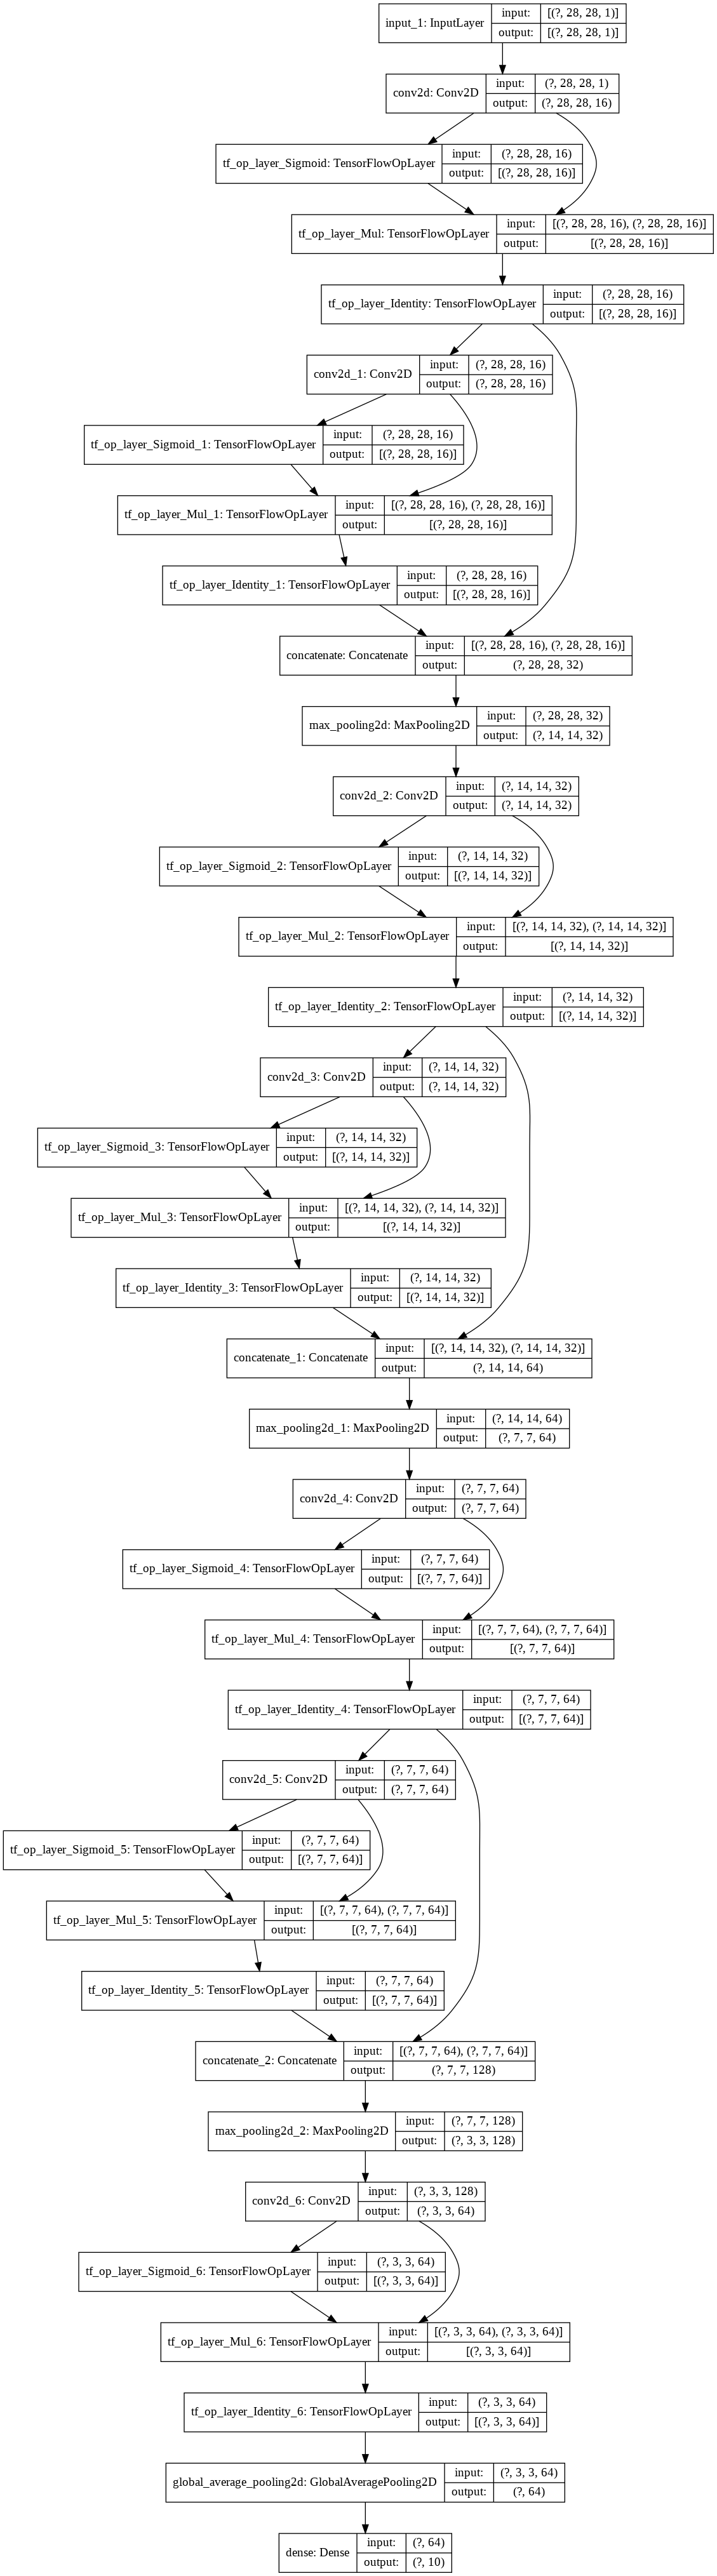

In [ ]:
# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/model.png')
from IPython.display import Image
Image(retina=True, filename='/content/model.png')

### **Define Callbacks**

In [ ]:
checkpoint = ModelCheckpoint(filepath='/content/model.h5', monitor='val_loss', mode='min', save_best_only=True)

### **Compile**

In [ ]:
# Instantiate the optimizer
optimizer = Adam(learning_rate=0.0006)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### **Train**

In [ ]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32, subset = 'training'), validation_data = datagen.flow(x_train, y_train, batch_size = 32, subset = 'validation'), epochs = 100, callbacks = [checkpoint])

Epoch 1/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.7812 - accuracy: 0.7039 - val_loss: 0.5772 - val_accuracy: 0.7777
Epoch 2/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.5308 - accuracy: 0.7958 - val_loss: 0.4738 - val_accuracy: 0.8183
Epoch 3/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.4578 - accuracy: 0.8249 - val_loss: 0.4434 - val_accuracy: 0.8300
Epoch 4/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.4127 - accuracy: 0.8402 - val_loss: 0.3736 - val_accuracy: 0.8607
Epoch 5/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.3765 - accuracy: 0.8570 - val_loss: 0.3681 - val_accuracy: 0.8580
Epoch 6/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.3542 - accuracy: 0.8666 - val_loss: 0.3329 - val_accuracy: 0.8747
Epoch 7/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.3343 - accuracy: 0.8747 - val_loss: 0

### **Predict and Visualize**

In [ ]:
# Load best model
model = load_model('/content/model.h5')

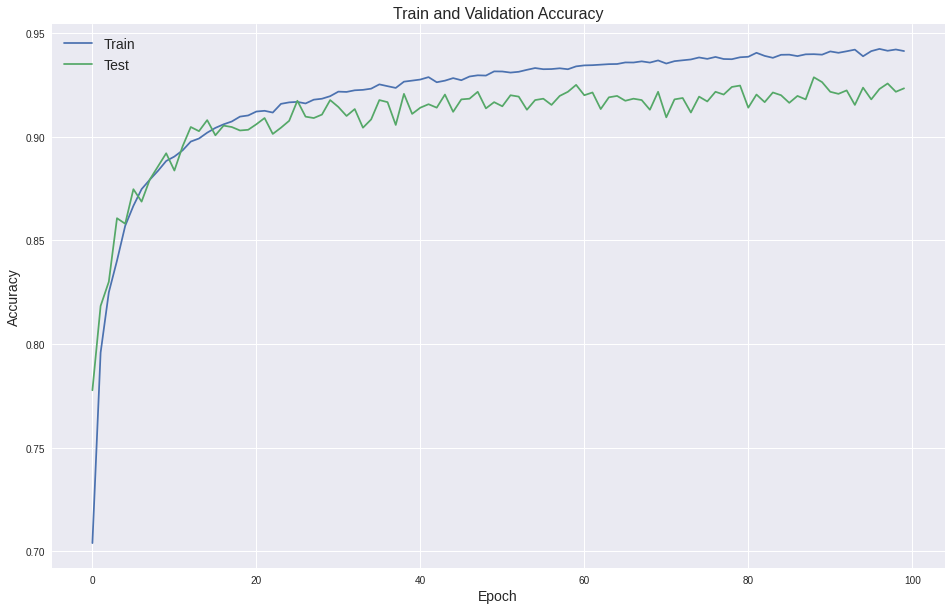

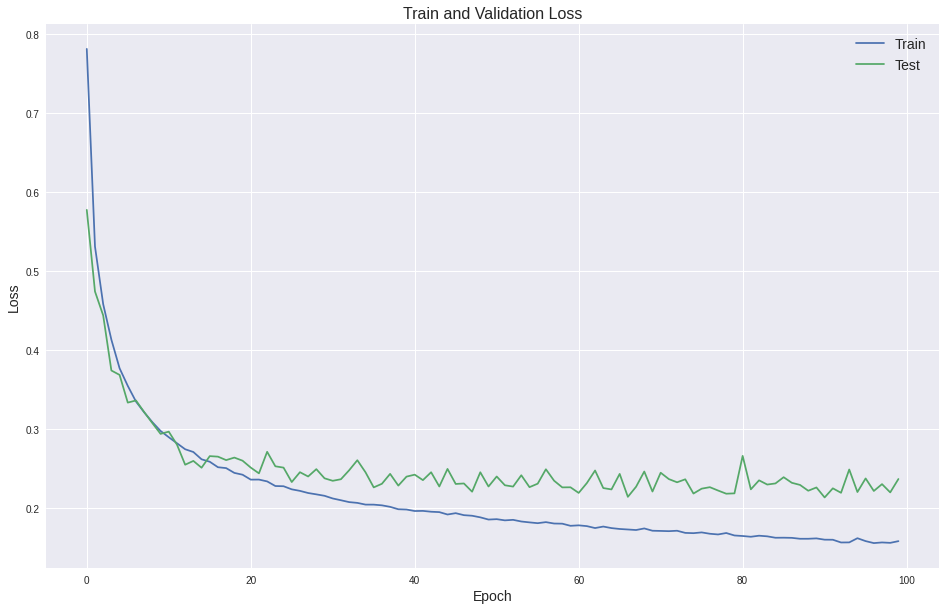

In [ ]:
# Train and Loss Curves

plt.style.use('seaborn')

# Summarize history for accuracy
plt.figure(1, figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train and Validation Accuracy', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Test'], fontsize = 14)
plt.show()

# Summarize history for loss
plt.figure(2, figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Test'], fontsize = 14)
plt.show()

In [ ]:
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classification_report(y_test.argmax(axis=1), model.predict(x_test/255.0).argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.87      0.88      0.87      1000
     Trouser       0.99      0.99      0.99      1000
    Pullover       0.93      0.88      0.90      1000
       Dress       0.93      0.92      0.92      1000
        Coat       0.90      0.89      0.89      1000
      Sandal       0.96      0.99      0.97      1000
       Shirt       0.76      0.81      0.78      1000
     Sneaker       0.97      0.96      0.96      1000
         Bag       0.99      0.99      0.99      1000
  Ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



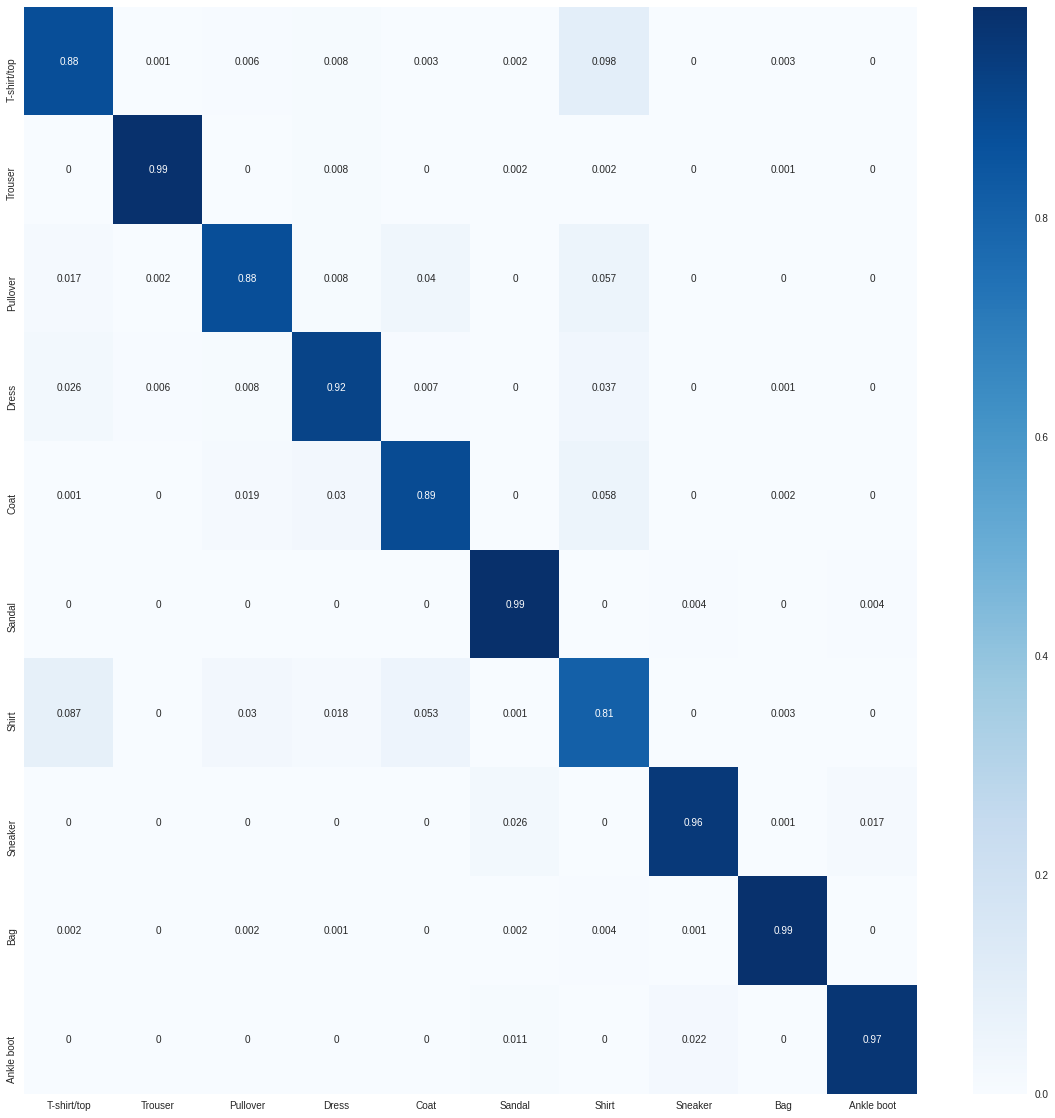

In [ ]:
cf_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test/255.0).argmax(axis=1))
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix/1000, annot=True, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

## **Part 3: Improve Model with BatchNorm and Dropout**

In this part we imporve our model with BatchNorm and Dropout and observe its effect. 



---

*   A `BatchNorm()` layer with default parameters is inserted **before the activation function** in every layer of every block.
*   Dropout has been set the **end of each block** with the exception of the first block.


---




### **Define Model with BatchNorm and Dropout**

In [ ]:
input = Input(shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))

# Block 1
x1_1 = Conv2D(16, (3, 3), padding='same')(input)
x1_1 = BatchNormalization()(x1_1)
x1_1 = swish(x1_1)
x1_2 = Conv2D(16, (3, 3), padding='same')(x1_1)
x1_2 = BatchNormalization()(x1_2)
x1_2 = swish(x1_2)
x = Concatenate(axis=-1)([x1_1, x1_2])
x = MaxPooling2D(pool_size=(2, 2))(x)

# Block 2
x2_1 = Conv2D(32, (3, 3), padding='same')(x)
x2_1 = BatchNormalization()(x2_1)
x2_1 = swish(x2_1)
x2_2 = Conv2D(32, (3, 3), padding='same')(x2_1)
x2_2 = BatchNormalization()(x2_2)
x2_2 = swish(x2_2)
x = Concatenate(axis=-1)([x2_1, x2_2])
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)

# Block 3
x3_1 = Conv2D(64, (3, 3), padding='same')(x)
x3_1 = BatchNormalization()(x3_1)
x3_1 = swish(x3_1)
x3_2 = Conv2D(64, (3, 3), padding='same')(x3_1)
x3_2 = BatchNormalization()(x3_2)
x3_2 = swish(x3_2)
x = Concatenate(axis=-1)([x3_1, x3_2])
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.1)(x)


# Reduce dimensionality and Global Average Pooling
reduce_dim = Conv2D(64, (1, 1), padding='same')(x)
reduce_dim = swish(reduce_dim)
gap = GlobalAveragePooling2D()(reduce_dim)
output = Dense(10, activation = 'softmax')(gap)

# Create model
model = Model(inputs=input, outputs=output, name="fashion_mnist_model")

### **Modified Model Summary**

In [ ]:
model.summary()

Model: "fashion_mnist_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 28, 28, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 28, 28, 16)   64          conv2d_14[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Sigmoid_14 (TensorF [(None, 28, 28, 16)] 0           batch_normalization_6[0][0]      
________________________________________________________________________________

### **Visualize Modified Model Architecture**

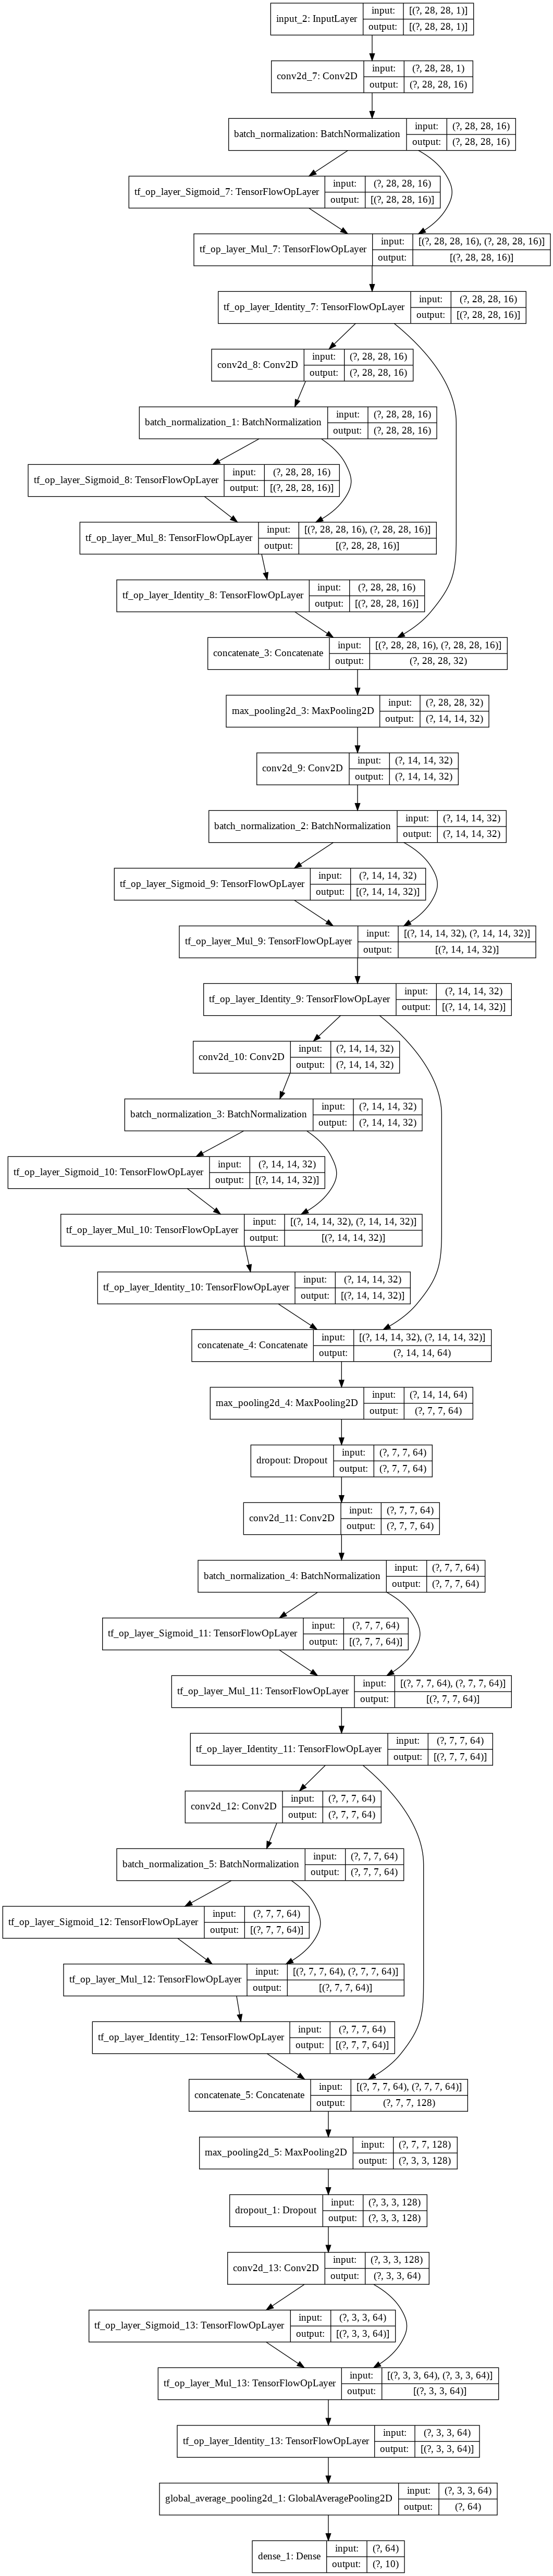

In [ ]:
# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='/content/model.png')
from IPython.display import Image
Image(retina=True, filename='/content/model.png')

### **Define Callbacks**

In [ ]:
#checkpoint = ModelCheckpoint(filepath='/content/model_batchnorm.h5', monitor='val_', mode='max', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.000001)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='min', restore_best_weights=True)

### **Compile**

In [ ]:
# Instantiate the optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

### **Train**

In [ ]:
# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size = 32, subset = 'training'), validation_data = datagen.flow(x_train, y_train, batch_size = 32, subset = 'validation'), epochs = 100, callbacks = [reduce_lr, early_stop])

Epoch 1/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.5887 - accuracy: 0.7814 - val_loss: 0.4077 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 2/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.4113 - accuracy: 0.8483 - val_loss: 0.3953 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 3/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.3640 - accuracy: 0.8643 - val_loss: 0.3060 - val_accuracy: 0.8877 - lr: 0.0010
Epoch 4/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.3341 - accuracy: 0.8773 - val_loss: 0.3082 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 5/100
1782/1782 [==============================] - 40s 22ms/step - loss: 0.3170 - accuracy: 0.8823 - val_loss: 0.2894 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 6/100
1782/1782 [==============================] - 39s 22ms/step - loss: 0.2988 - accuracy: 0.8894 - val_loss: 0.2944 - val_accuracy: 0.8823 - lr: 0.0010
Epoch 7/100
1782/1782 [=================

### **Save Model**



---

We need to save the model manually since the `EarlyStopping` callback does not save the model by default.


---



In [ ]:
# Save model 
model.save('/content/model_batchnorm.h5')

### **Predict and Visualize**

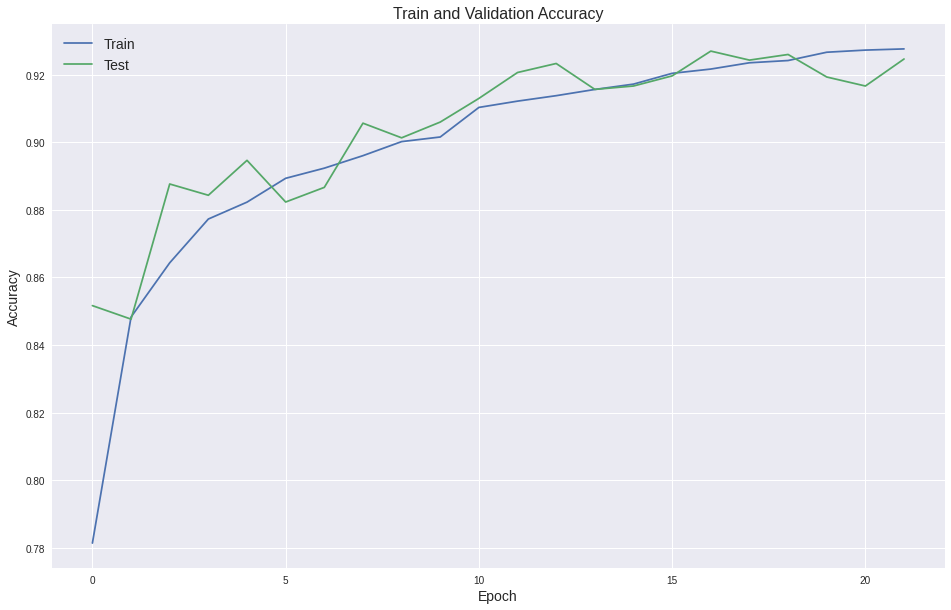

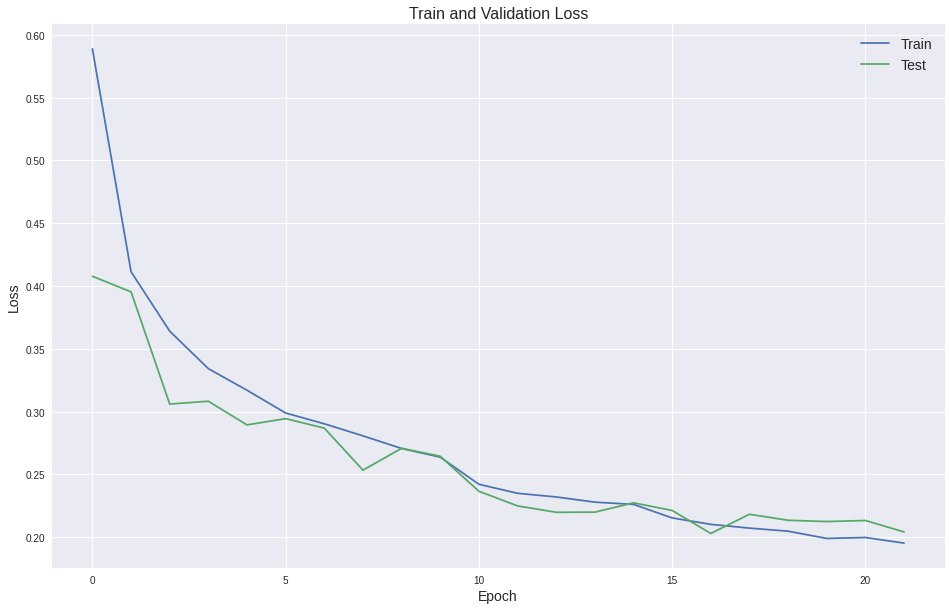

In [ ]:
# Train and Loss Curves

plt.style.use('seaborn')

# Summarize history for accuracy
plt.figure(1, figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train and Validation Accuracy', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Test'], fontsize = 14)
plt.show()

# Summarize history for loss
plt.figure(2, figsize=(16, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train and Validation Loss', fontsize = 16)
plt.ylabel('Loss', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)
plt.legend(['Train', 'Test'], fontsize = 14)
plt.show()

In [ ]:
target_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
print(classification_report(y_test.argmax(axis=1), model.predict(x_test/255.0).argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

 T-shirt/top       0.91      0.84      0.87      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.92      0.86      0.89      1000
       Dress       0.93      0.91      0.92      1000
        Coat       0.90      0.87      0.89      1000
      Sandal       0.98      0.99      0.98      1000
       Shirt       0.71      0.85      0.78      1000
     Sneaker       0.95      0.97      0.96      1000
         Bag       0.98      0.99      0.99      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.92      0.92     10000



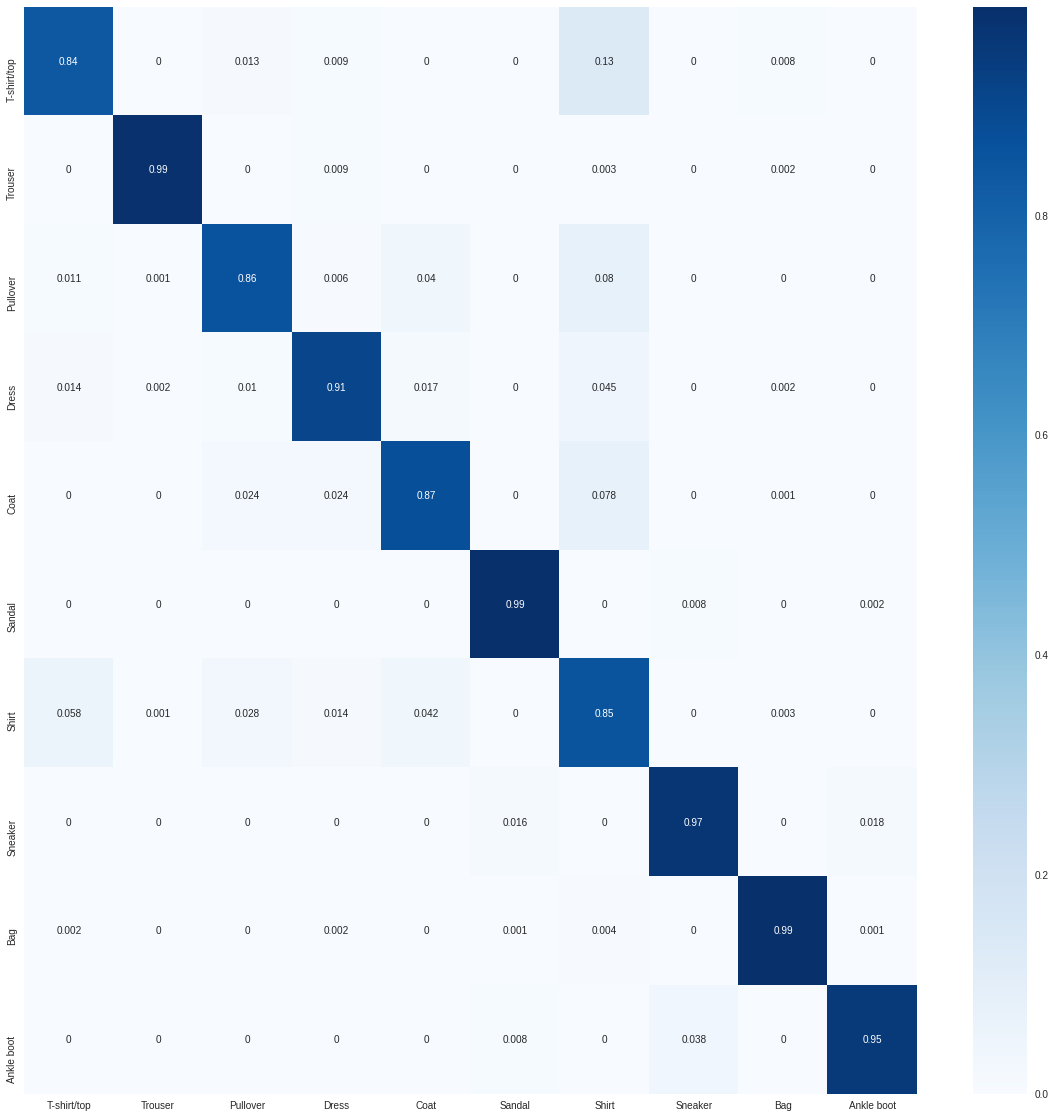

In [ ]:
cf_matrix = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test/255.0).argmax(axis=1))
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix/1000, annot=True, xticklabels=target_names, yticklabels=target_names, cmap='Blues')

# **Conclusion**



---

**Summary and Conclusions:**

1.   Both the models achieve **~92.5% (92.57% and 92.42%) accuracy on the test set with only ~0.1M (100K) parameters.**


2.   Both the models **beat AlexNet which achieves 90.00% along with several other models like SqueezeNet and Dyra-Net.** 


3.   It also **beats several light models in the official benchmark** like the ones by https://github.com/abelusha (92.22% ~0.13M parameters) and https://twitter.com/hardmaru (92.5%, ~0.1M parameters)


4.  Both the models can also be compared to models like **VGG16** that achieves an impressive accuracy of **93.5% but at the cost of 26M (26000K) parameters or Capsule Netowrk (93.6%, 8M parameters) and GoogleNet (93.7%, 6.78M parameters)** 


5.  **Model with BatchNorm takes only 22 epochs** whereas the **model without it takes 97 epochs** to converge to the **same test accuracy of ~92.5%.** 


6.  This roughly translates to the fact that **the model without BatchNorm took 4.4x more time than taken by the model with BatchNorm. Using BatchNorm drastically improves convergence.**


7.  From the loss and accuracy curves of both models, we can observe that the **model with BatchNorm is less noisy and does not diverge from the training curve over the period of training.** This is due to **Early Stopping** since it exits training if divergence persists for a set number of epochs. 


8. ReduceLROnPlateau also contributes to a smooth validation curve **since it lowers the learning rate everytime the model tries to update its weights in the direction of overfitting.** 


---



